In [6]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re

In [2]:
df = pd.read_csv('SPAM_text_message_20170820.csv')

In [3]:
df.head()

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


# Clean the Messages text

In [7]:
# Function to clean text (keep only words)
def clean_text(text):
    text = re.sub(r'[^A-Za-z]', ' ', text)  # Remove everything except letters
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra spaces
    return text.lower()  # Convert to lowercase

# Apply cleaning function to messages
df['Message'] = df['Message'].apply(clean_text)

In [8]:
df.head()

,Category,Message
0,ham,go until jurong point crazy available only in ...
1,ham,ok lar joking wif u oni
2,spam,free entry in a wkly comp to win fa cup final ...
3,ham,u dun say so early hor u c already then say
4,ham,nah i don t think he goes to usf he lives arou...


<Axes: xlabel='Category'>

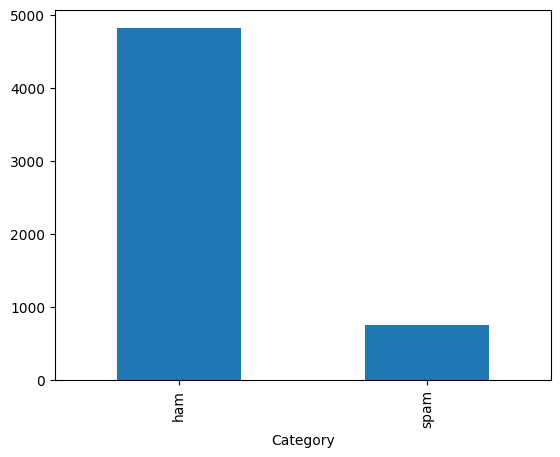

In [10]:
df['Category'].value_counts().plot(kind='bar')

# Remove stopwords

In [13]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

In [14]:
# Download stopwords if not available
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /home/parvez/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [15]:
# Function to remove stopwords
def remove_stopwords(text):
    words = text.split()  # Tokenize (split into words)
    words = [word for word in words if word not in stop_words]  # Remove stopwords
    return ' '.join(words)  # Join back into a single string

In [16]:
df['Category'] = df['Category'].apply(remove_stopwords)

In [22]:
df.head(20)

,Category,Message
0,ham,go until jurong point crazy available only in ...
1,ham,ok lar joking wif u oni
2,spam,free entry in a wkly comp to win fa cup final ...
3,ham,u dun say so early hor u c already then say
4,ham,nah i don t think he goes to usf he lives arou...
5,spam,freemsg hey there darling it s been week s now...
6,ham,even my brother is not like to speak with me t...
7,ham,as per your request melle melle oru minnaminun...
8,spam,winner as a valued network customer you have b...
9,spam,had your mobile months or more u r entitled to...


# label encode the category column

In [26]:
# Convert labels to binary (0 for ham, 1 for spam)
df['Category'] = df['Category'].map({'ham': 0, 'spam': 1})

In [24]:
X = df['Message']
y = df['Category']

In [25]:
X.shape , y.shape

((5572,), (5572,))

In [30]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense

In [32]:
import tensorflow as tf
print(tf.__version__)

2.19.0


In [33]:
# Tokenize text
tokenizer = Tokenizer(num_words=5000, oov_token="<OOV>")
tokenizer.fit_on_texts(X)
sequences = tokenizer.texts_to_sequences(X)

In [34]:
# Pad sequences
max_length = 10  # Keep it small
X_padded = pad_sequences(sequences, maxlen=max_length, padding='post')

In [36]:
X_padded.shape

(5572, 10)

In [37]:
from sklearn.model_selection import train_test_split
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_padded, y, test_size=0.2, random_state=42)

# LSTM model

In [59]:
model = Sequential([
    Embedding(input_dim=5000, output_dim=32, input_length=10),  # Set input_length
    LSTM(16, return_sequences=False),  # Ensure LSTM has proper input
    Dense(1, activation='sigmoid')  # Binary classification
])
model.build(input_shape=(None, 10))  # Force build the model

In [60]:
model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_7 (Embedding)         │ (None, 10, 32)         │       160,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 16)             │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 163,153 (637.32 KB)

 Trainable params: 163,153 (637.32 KB)

 Non-trainable params: 0 (0.00 B)

In [61]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [62]:
# Train
model_history = model.fit(X_train, y_train, epochs=10, batch_size=1000, validation_data=(X_test, y_test))

Epoch 1/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 0.6461 - loss: 0.6741 - val_accuracy: 0.8771 - val_loss: 0.5920
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.8761 - loss: 0.5723 - val_accuracy: 0.8789 - val_loss: 0.5068
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.8834 - loss: 0.4902 - val_accuracy: 0.8834 - val_loss: 0.4347
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.8879 - loss: 0.4195 - val_accuracy: 0.8897 - val_loss: 0.3702
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.8902 - loss: 0.3559 - val_accuracy: 0.8933 - val_loss: 0.3151
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.8967 - loss: 0.3036 - val_accuracy: 0.9031 - val_loss: 0.2711
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.9022 - loss: 0.2651 - val_accuracy: 0.9103 - val_loss: 0.2384
Epoch 8/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.9176 - loss: 0.2278 - val_accuracy: 0.9157 - val_loss: 0.2146


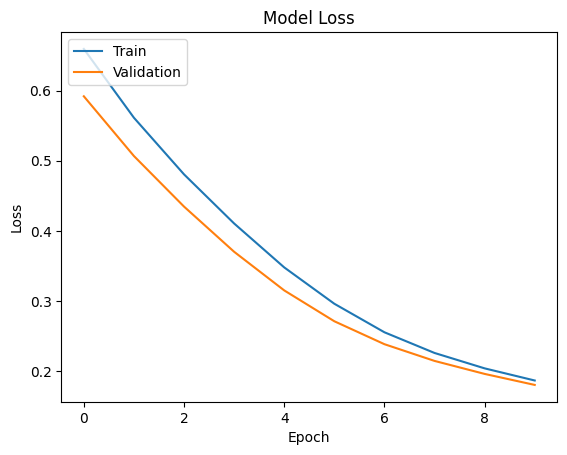

In [63]:
# Plot loss
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

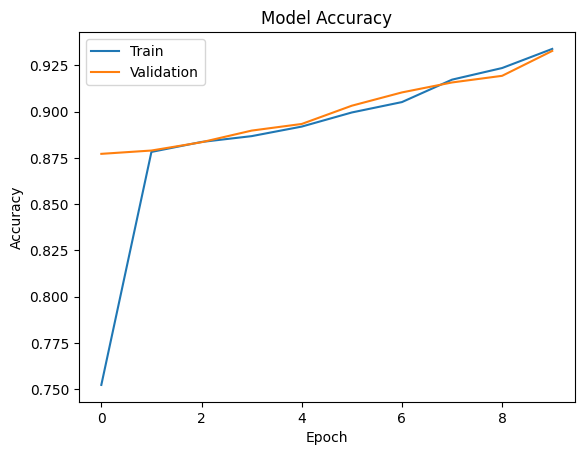

In [64]:
# Plot accuracy
plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [76]:
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5)
y_pred

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


array([[False],
       [False],
       [False],
       ...,
       [False],
       [False],
       [False]])

In [81]:
from sklearn.metrics import confusion_matrix, accuracy_score
score = accuracy_score(y_test, y_pred)
print("Test Accuracy:", score)

cm = confusion_matrix(y_test, y_pred)
cm

Test Accuracy: 0.9327354260089686


array([[966,   0],
       [ 75,  74]])

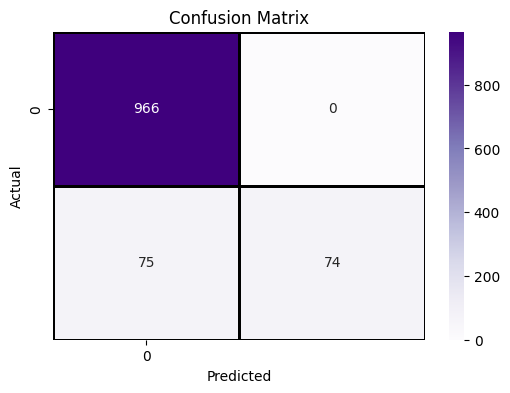

In [82]:
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples',linewidths=1, linecolor='black', xticklabels=4, yticklabels=4)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()